In [2]:
#BEGIN
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{ "size":16}) #**{,,'serif':['Palatino']
rc('text', usetex=True) # turn this off if there is no latex
import numpy.random as rnd
rnd.seed()
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
from scipy.optimize import brentq as solve
from scipy.integrate import odeint as ode
from scipy.special import gamma
np.set_printoptions(precision = 3, suppress = 1)
from matplotlib import cm
color = cm.get_cmap("Blues")

# Physics in 1D: introduction to bosonization

Bosonization is an interesting technique to deal with low-energy properties of fermions in one dimension, by mapping them to bosons. In particular, some interacting fermionic models map to free boson models. But to introduce the mapping we need to work on free fermions and free bosons for a while (bear with us). 

## Non-interacting fermions

Consider the simple tight binding model of complex fermions:

$$ H = t \sum_j (c_{j+1}^{\dagger} c_j + c_{j}^{\dagger} c_{j+1}) $$

- Rewrite the Hamiltonian in terms of the Majorana fermions 
$$ \gamma_j =  c_j + c_j^\dagger \,,\,  \eta_j =  \mathrm{i} (c_j - c_j^\dagger) $$
(recall also what anticommutation relations they satisfy). Can we make a connection to the Ising model? (See illustration below)

(-1.0, 1.0)

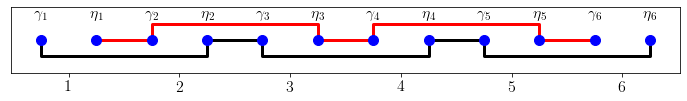

In [92]:
L = 6
plt.figure(1, figsize=(12,1.2))
for j in range(1,L):
    #plt.plot([j+.5, j+.5],[-1,1],"k")
    plt.plot([j+.25, j+.75],[0,0], lw=3, c = "r" if j % 2 else "k" )
    y = (-1) ** (j % 2) * .5
    plt.plot([j-.25, j - .25, j + 1.25, j + 1.25], [0, y, y, 0], c = "k" if j % 2 else "r", lw=3)
    #plt.text(j+.5, -.2, r"$J$", va = "top", ha = "center" )
for j in range(1,L+1):
    
    plt.text(j-.25, .6, r"$\gamma_{%d}$" % j, va = "bottom", ha = "center" )
    plt.text(j+.25, .6, r"$\eta_{%d}$" % j, va = "bottom", ha = "center" )
    #plt.text(j-.25, .6, r"$\psi_{%d}$" % (2 * j-1), va = "bottom", ha = "center" )
    #plt.text(j+.25, .6, r"$\psi_{%d}$" % (j*2), va = "bottom", ha = "center" )
    
  #  plt.text(j, -.2, r"$h$", va = "top", ha = "center" )
plt.plot(np.arange(1,L+1) - .25, np.zeros(L), "o", c = "b", ms = 10)
plt.plot(np.arange(1,L+1) + .25, np.zeros(L), "o", c = "b", ms = 10)

plt.yticks([])
plt.xticks(np.arange(L)+1)
plt.ylim(-1,1)

- By going to momentum space, show that its low-energy excitations are described by a field theory with two chiral fermions, and the following Hamiltonian defined on a ring of size $2\pi$:

$$ H = \int_0^{2\pi} \mathrm{d} x  \, \mathrm{i} \left[ \psi_L^\dagger \partial_x \psi_L -  \psi_R^\dagger \partial_x \psi_R \right] \propto \sum_{q \in \mathbf{Z} + \frac12}  \left[ q \, \psi_L^\dagger(q) \psi_L(q) -  q \, \psi_R^\dagger(q) \psi_R(q) \right] $$

We assume that the sum over $q$ is over half-integers for convenience (to avoid zero modes). In practice, this can be done by having a periodic chain with $N$ fermions such that $N \equiv 2 \; \mathrm{mod} \; 4$. In field theory parlance, $\psi_{L,R}$ satisfies an antiperiodic boundary condition. (See below for illustration)

#### Appendix: Fourier transform convention

$$ f(x) = \sum_q f(q) e^{-i q x}  \,,\, f(q) = \frac1{2\pi} \int \mathrm{d} x f(x) e^{i q x}  $$

Text(0, 0.5, '$\\epsilon_q$ (a.u.)')

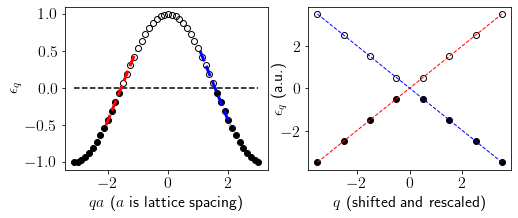

In [96]:
L = 50

fig, ax = plt.subplots(1,2, figsize = (8,3))
plt.sca(ax[0])
qs = np.arange(-L//2,L//2) / L * np.pi * 2
eps = np.cos(qs) 
plt.plot(qs[eps < 0], eps[eps < 0], "o", c = "k", markersize = 6)
plt.plot(qs[eps > 0], eps[eps > 0], "o", fillstyle="none", c = "k", markersize = 6)

xs = np.array([qs[0], qs[-1]])
plt.plot(xs, 0 * xs, c="k", ls = "--")

xs = np.linspace(-.5, .5, 3)
plt.plot(xs -  np.pi/2, xs, "r--", lw = 3 )

plt.plot(xs + np.pi/2, -xs, "b--", lw = 3 )

plt.xlabel(r"$q a$ ($a$ is lattice spacing)")
plt.ylabel(r"$\epsilon_q$")

plt.sca(ax[1])

xs = np.arange(-4, 4) + .5

plt.plot(xs[xs > 0], xs[xs > 0], "o", c = "k", fillstyle="none",)
plt.plot(xs[xs < 0], xs[xs < 0], "o", c = "k")
plt.plot(xs, xs, "r--", lw= 1)

plt.plot(xs[xs > 0], -xs[xs > 0], "o", c = "k",)
plt.plot(xs[xs < 0], -xs[xs < 0], "o", c = "k",  fillstyle="none",)

plt.plot(xs, -xs, "b--", lw= 1)
plt.xlabel(r"$q$ (shifted and rescaled)")
plt.ylabel(r"$\epsilon_q$ (a.u.)", labelpad = -5)


## Free bosons in (1+1)-d

We now take a break from the fermions and look at a 2D GFF on a cylinder of length $2\pi$. The Euclidean action is 

$$ S = \frac1{4 \pi} \int_{\mathbb{R}} \mathrm{d} \tau \int_{0}^{2\pi} \mathrm{d} x  \left[ (\partial_\tau \phi)^2 + (\partial_x \phi)^2  \right]  $$

Recall that the Green function is logarithmically divergent
$$ \left< \phi(x) \phi(0) \right> \sim - \ln |x| \,,\, |x| \to 0 \,. $$ 

- Quantize the path integral and show that the quantum Hamiltonian is as follows in the momentum space
$$ H \propto \sum_{k = 1}^\infty  a_{k}^\dagger a_{k} + \sum_{k = 1}^\infty  b_{k}^\dagger b_{k}  + H_0 \,,\, H_0 \propto \pi_0^2  $$
Here $H_0$ governs the unbounded zero mode fluctuation, which we usually eliminate (by requiring that the GFF has no zero mode). 


The ladder operators 
$$a_k = \frac1{\sqrt{2}} (\pi_k - \mathrm{i} k \phi_k) , b_k = \frac1{\sqrt{2}} (\pi_{-k} - \mathrm{i} k \phi_{-k}) $$ satisfy the **boson algebra** 
$$ [a_k, a_j^{\dagger}] = [b_k, b_j^{\dagger}] = k \delta_{jk} \,. $$
It is also useful to note that $a_{-k} = a_k^\dagger$, $b_{-k} = b_k^\dagger$. Physically, the decomposed the nonzero modes of the (1+1)-d free boson into left and right moving modes. Classically, the solutions to the wave equation $ (\partial_t^2 - \partial_x^2) \phi = 0$ can be always decomposed into left and right moving waves, $\phi = \phi_L(x + t) + \phi_R(x - t)$. 

## Boson algebra from fermion Fock space

This is the heart of bosonization: a representation of the boson algebra in the Fock space of one chiral fermion, say $\psi = \psi_L$. Its creation and annihilation operators in the momentum space have anticommutation relations 
$$ \{ \psi_q, \psi_{q'}^\dagger \} = \delta_{p,q'} $$

**Claim**. The operators
$$ \boxed{n_k := \sum_{q} \psi_q^\dagger \psi_{q + k}} \,,\, k \in \mathbb{Z} \setminus \{0\}$$
Satisfies the boson algebra, namely $[n_j, n_{k}^\dagger] = k \delta_{j,k}$, **if** we restrict to the Fock space of states that are a finite number of excitations away from the Fermi sea vacuum.

One can prove this algebraically. A nice "combinatorial" way to understand this is to count the number of eligible particle-hole pairs $n_{k}$ can act on. See the demonstration below. The point is that there are always $k$ more eligible pairs for $n_k^\dagger$ (creation) than for $n_k$ (annihilation). The logic is similar to the infinite hotel paradox.

- How does that work for $\psi_R$?

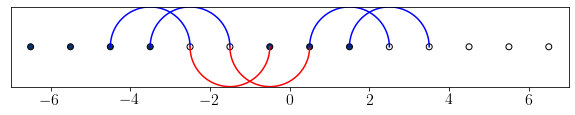

In [156]:
k = 2  # number of 
qmax = 7

#fig,ax = plt.subplots(2,1, figsize = (10, 3))
plt.figure(1, figsize = (10, 3))
########### Fermi sea
qs = np.arange(qmax * 2) - qmax + .5
occupy = np.zeros(qmax * 2, dtype=int)
occupy[:qmax] = 1

############# some random excitations

particles = np.array([1,2,])
holes = np.array([2,3])

occupy[particles + qmax - 1] = 1

occupy[-holes + qmax] = 0


#############
#plt.sca(ax[0])
plt.scatter(qs, qs * 0, c = occupy, cmap = "Blues", edgecolor = "k")
plt.xlim(-qmax , qmax  )
#plt.yticks([])
#plt.sca(ax[1])
#plt.scatter(qs + k, qs * 0 - 1, c = occupy, cmap = "Blues", edgecolor = "k")
#plt.xlim(-qmax - k, qmax + k)

plt.yticks([])
#plt.xticks(qs, [r"$\frac{%d}{2}$" % (q * 2) for q in qs])

for j in range(qmax * 2 - k):
    if occupy[j] and not occupy[j + k]:
        x1, x2 = qs[j], qs[j+k]
        ths = np.linspace(0, np.pi, 50)
        plt.plot(np.cos(ths) * (x1 - x2)/2 + (x1 + x2) / 2, np.sin(ths) / 2 * k, c = "b")
    if not occupy[j] and occupy[j + k]:
        x1, x2 = qs[j], qs[j+k]
        ths = np.linspace(0, np.pi, 50)
        plt.plot(np.cos(ths) * (x1 - x2)/2 + (x1 + x2) / 2, -np.sin(ths) / 2 * k, c = "r")
plt.ylim(- k / 2, k / 2)
#
plt.gca().set_aspect("equal")
#plt.title("$k = %d$, " % k)
plt.subplots_adjust(hspace = .2)

## Application: calculating $\Delta_{\sigma}$ of Ising


$$ \{ \psi_q^\dagger, \psi_q \} =  1 \implies \{ \psi(x),  \psi(y) \} = 2 \pi \delta(x - y) $$

Therefore
$$ \psi(x)_L^\dagger \psi_L(x) +  \psi(x)_R^\dagger \psi_R(x) = 2\pi n(x) $$

On the other hand, with boson representation 

$$  \psi(x)_L^\dagger \psi_L(x) +  \psi(x)_R^\dagger \psi_R(x) = \sqrt{2}\partial_x \phi(x)  $$


$$ \prod_{j=x_1}^{x_2} (-1)^{c_j^\dagger c_j} =  \exp( \mathrm{i} \pi \int_{x_1}^{x_2} n(y) \mathrm{d} y ) = \exp\left( \frac{\mathrm{i}}{\sqrt{2}} (\phi(x_2) - \phi(x_1)) \right) \propto |x_2 - x_1|^{1/2}$$

Now since one fermion chain is two Ising chains (see above, and $ \prod_{j=x_1}^{x_2} (-1)^{c_j^\dagger c_j} $ maps to a string of $\gamma$'s, which in turn maps to $Z_{x_1} Z_{x_2}$ via Jordan-Wigner)

$$ 2 \Delta_{\sigma} = \frac14$$

Text(0, 0.5, '$\\prod_{j \\le x} (-1)^{n_j}$')

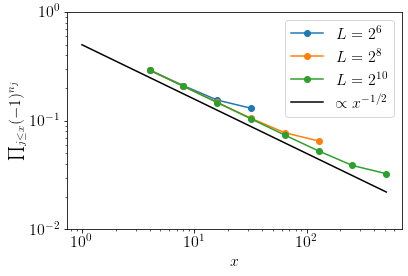

In [72]:
for lb in np.arange(6, 12, 2):
    L = 2 ** lb 
    es = np.cos(np.arange(L) / L * np.pi * 2)
    index =  (es <= 0) 
    gr = np.fft.fft(np.identity(L)[index], axis = 1) / L ** .5
    gr1 = np.array(gr)
    res = []
    xs = 2 ** np.arange(0,lb) 
    for j in xs:
        gr1[:,:] = gr
        gr1[:, :j] *= -1
        res.append(la.det( gr @ gr1.T.conj()).real)
    plt.loglog(xs[2:], res[2:], "o-", label=r"$L=2^{%d}$"% lb)
plt.ylim(1e-2, 1)
plt.plot(xs, xs ** -.5 / 2, "k", label= r"$\propto x^{-1/2}$")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$\prod_{j \le x} (-1)^{n_j}$")